In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import chardet
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout, GlobalMaxPool1D, Conv1D
from keras.layers import Embedding
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import utils
from keras.utils import np_utils

import seaborn as sns


from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras import utils as np_utils
from keras.utils.np_utils import to_categorical

import transformers
from transformers import AutoTokenizer,TFDistilBertModel, DistilBertConfig
from transformers import TFAutoModel

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install -U -q PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
fileDownloaded = drive.CreateFile({'id':'1WPo4J9wi0bIXl2I5da_UYc1UqV8q_iRw'})
fileDownloaded.GetContentFile('data_init.csv')

In [37]:
with open('data_init.csv', 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'encoding': 'Windows-1254',
 'confidence': 0.4445340489203496,
 'language': 'Turkish'}

In [41]:
df = pd.read_csv('data_init.csv',encoding='iso-8859-1',error_bad_lines=False, index_col = False)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572928 entries, 0 to 572927
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ProductId                  572928 non-null  int64  
 1   Manufacturer Account Name  572928 non-null  object 
 2   Brand/Label                572928 non-null  object 
 3   IDEA''s Public ID          572928 non-null  int64  
 4   UPC Number                 525059 non-null  float64
 5   EAN Number                 115523 non-null  float64
 6   Catalog Number             572928 non-null  object 
 7   Invoice Description        572928 non-null  object 
 8   Catalog Description        387640 non-null  object 
 9   UNSPSC code                567206 non-null  float64
 10  IGCC code                  385015 non-null  float64
 11  CMD Category               567195 non-null  object 
 12  GTIN                       390194 non-null  float64
dtypes: float64(5), int64(2), obje

In [44]:
cmd_count = df['CMD Category'].value_counts()
df['CMD_COUNT'] = df['CMD Category'].map(df['CMD Category'].value_counts())
cmd_count
threthold = 1000
others_count = cmd_count[cmd_count <=threthold ].count()
others_sum = cmd_count[cmd_count <= threthold].sum()
total = cmd_count.sum()
other_pct = others_sum/total*100
print("When threthold is", threthold, ", the total number of CMD categories moved to'other' categories is", others_count)
print("The total products in 'other' category is", others_sum)
print("Percentage of products that grouped in the 'other' category is", f'{other_pct:.2f}',"%")

When threthold is 1000 , the total number of CMD categories moved to'other' categories is 2429
The total products in 'other' category is 159837
Percentage of products that grouped in the 'other' category is 28.18 %


In [45]:
df.loc[df["CMD_COUNT"] <= 1000, "CMD Category"] = "Other"

In [46]:
cmd_count = df['CMD Category'].value_counts()
cmd_count

Other                                                  159837
Cable tray fitting and accessories                      21095
Circuit breakers                                        17929
Molded case circuit breakers                            17075
Electrical equipment maintenance and repair service     13541
                                                        ...  
Circular connectors                                      1041
Incandescent lamps                                       1034
Cartridge fuses                                          1029
Remote lighting fixture                                  1024
Midget fuses                                             1016
Name: CMD Category, Length: 130, dtype: int64

In [50]:
df = df[df['CMD Category']!= 'Other']
df_test = df.sample(n=10000)

In [53]:
sentences = df_test['Invoice Description']
y = df_test['CMD Category']
sentences_train, sentences_test, train_y, test_y = train_test_split(sentences, y, test_size=0.3, random_state=42)

In [54]:
print(sentences_train.shape)
print(sentences_test.shape)
print(train_y.shape)
print(test_y.shape)

(7000,)
(3000,)
(7000,)
(3000,)


In [55]:
tokenize = Tokenizer(num_words=1000)
tokenize.fit_on_texts(sentences_train)


In [56]:
X_train = tokenize.texts_to_sequences(sentences_train)
X_test = tokenize.texts_to_sequences(sentences_test)

In [57]:
vocab_size = len(tokenize.word_index) + 1

In [58]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])


[ 33   9 260  85 284 330   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


In [59]:
train_y = train_y.astype('str')
test_y = test_y.astype('str')

encoder = LabelEncoder()
encoder.fit(train_y)
y_train = encoder.transform(train_y)
y_test = encoder.transform(test_y)

num_classes = np.max(y_train) + 1
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [60]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [70]:
embedding_dim = 16

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(130, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',f1_m])
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 100, 16)           131472    
                                                                 
 flatten_4 (Flatten)         (None, 1600)              0         
                                                                 
 dense_22 (Dense)            (None, 128)               204928    
                                                                 
 dense_23 (Dense)            (None, 130)               16770     
                                                                 
Total params: 353,170
Trainable params: 353,170
Non-trainable params: 0
_________________________________________________________________


In [71]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_1.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [72]:
!pip install pydot

You should consider upgrading via the '/Users/haibilu/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [73]:
history1 = model.fit(X_train, y_train,
                    batch_size= 32,
                    epochs=30,
                    validation_data=(X_test, y_test))

Epoch 1/30
219/219 [==============================] - 1s 3ms/step - loss: 4.4815 - accuracy: 0.0763 - f1_m: 0.0052 - val_loss: 4.1704 - val_accuracy: 0.1520 - val_f1_m: 0.0210
Epoch 2/30
219/219 [==============================] - 1s 2ms/step - loss: 3.7872 - accuracy: 0.2044 - f1_m: 0.1328 - val_loss: 3.5169 - val_accuracy: 0.2360 - val_f1_m: 0.1517
Epoch 3/30
219/219 [==============================] - 1s 3ms/step - loss: 3.1362 - accuracy: 0.3336 - f1_m: 0.2774 - val_loss: 2.9671 - val_accuracy: 0.3737 - val_f1_m: 0.3114
Epoch 4/30
219/219 [==============================] - 1s 2ms/step - loss: 2.5822 - accuracy: 0.4363 - f1_m: 0.3989 - val_loss: 2.6054 - val_accuracy: 0.4193 - val_f1_m: 0.3974
Epoch 5/30
219/219 [==============================] - 1s 3ms/step - loss: 2.1919 - accuracy: 0.5031 - f1_m: 0.4721 - val_loss: 2.3797 - val_accuracy: 0.4540 - val_f1_m: 0.4533
Epoch 6/30
219/219 [==============================] - 1s 2ms/step - loss: 1.9341 - accuracy: 0.5477 - f1_m: 0.5347 - val

In [86]:
embedding_dim = 50

model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model2.add(GlobalMaxPool1D())
#model2.add(layers.Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(192, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(130, activation='softmax'))

model2.compile(optimizer='Adam',
               loss='categorical_crossentropy',
               metrics=['accuracy',f1_m])

model2.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 100, 50)           410850    
                                                                 
 global_max_pooling1d_14 (Gl  (None, 50)               0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_24 (Dropout)        (None, 50)                0         
                                                                 
 dense_34 (Dense)            (None, 192)               9792      
                                                                 
 dropout_25 (Dropout)        (None, 192)               0         
                                                                 
 dense_35 (Dense)            (None, 130)               25090     
                                                     

In [87]:
#plot_model(model2, to_file='model_1.png', show_shapes=True, show_layer_names=True)

In [88]:
#!pip install graphviz

In [89]:
history_2 = model2.fit(X_train, y_train,
                       batch_size=32,
                       epochs=30,
                       validation_data=(X_test, y_test))

Epoch 1/30
219/219 [==============================] - 1s 4ms/step - loss: 4.5625 - accuracy: 0.0490 - f1_m: 0.0000e+00 - val_loss: 4.3117 - val_accuracy: 0.0617 - val_f1_m: 0.0000e+00
Epoch 2/30
219/219 [==============================] - 1s 3ms/step - loss: 4.1280 - accuracy: 0.0986 - f1_m: 0.0297 - val_loss: 3.9171 - val_accuracy: 0.1640 - val_f1_m: 0.0472
Epoch 3/30
219/219 [==============================] - 1s 3ms/step - loss: 3.7416 - accuracy: 0.1820 - f1_m: 0.1062 - val_loss: 3.4978 - val_accuracy: 0.2873 - val_f1_m: 0.1613
Epoch 4/30
219/219 [==============================] - 1s 3ms/step - loss: 3.3910 - accuracy: 0.2664 - f1_m: 0.1804 - val_loss: 3.1388 - val_accuracy: 0.3640 - val_f1_m: 0.2092
Epoch 5/30
219/219 [==============================] - 1s 3ms/step - loss: 3.0878 - accuracy: 0.3299 - f1_m: 0.2463 - val_loss: 2.8663 - val_accuracy: 0.3950 - val_f1_m: 0.3449
Epoch 6/30
219/219 [==============================] - 1s 3ms/step - loss: 2.8490 - accuracy: 0.3521 - f1_m: 0.30

In [ ]:
#keras.utils.plot_model(model2, show_shapes=True, dpi=90)

In [ ]:
#!pip install pydot
#!pip install graphviz

In [90]:
embedding_dim = 100

model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model3.add(Conv1D(128, 5, activation='relu'))
model3.add(GlobalMaxPool1D())
model3.add(Dropout(0.5))
#model3.add(layers.Flatten())
model3.add(Dense(224, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(130, activation='softmax'))
#optimizer = keras.optimizers.Adam(lr=0.00005)
model3.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy',f1_m])

model3.summary()




Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 100, 100)          821700    
                                                                 
 conv1d_8 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_15 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_36 (Dense)            (None, 224)               28896     
                                                                 
 dropout_27 (Dropout)        (None, 224)               0         
                                                     

In [91]:
history3 = model3.fit(X_train, y_train,
                       batch_size=16,
                       epochs=15,
                       validation_data=(X_test, y_test))

Epoch 1/15
438/438 [==============================] - 5s 10ms/step - loss: 4.1077 - accuracy: 0.1311 - f1_m: 0.1005 - val_loss: 3.4527 - val_accuracy: 0.2727 - val_f1_m: 0.2247
Epoch 2/15
438/438 [==============================] - 4s 10ms/step - loss: 3.1640 - accuracy: 0.3113 - f1_m: 0.3188 - val_loss: 2.8223 - val_accuracy: 0.3953 - val_f1_m: 0.4029
Epoch 3/15
438/438 [==============================] - 5s 11ms/step - loss: 2.6188 - accuracy: 0.4121 - f1_m: 0.4284 - val_loss: 2.4344 - val_accuracy: 0.4717 - val_f1_m: 0.4783
Epoch 4/15
438/438 [==============================] - 4s 10ms/step - loss: 2.2345 - accuracy: 0.4696 - f1_m: 0.4906 - val_loss: 2.1824 - val_accuracy: 0.5060 - val_f1_m: 0.5360
Epoch 5/15
438/438 [==============================] - 4s 10ms/step - loss: 1.9756 - accuracy: 0.5194 - f1_m: 0.5486 - val_loss: 2.0317 - val_accuracy: 0.5210 - val_f1_m: 0.5588
Epoch 6/15
438/438 [==============================] - 4s 10ms/step - loss: 1.7916 - accuracy: 0.5517 - f1_m: 0.5768

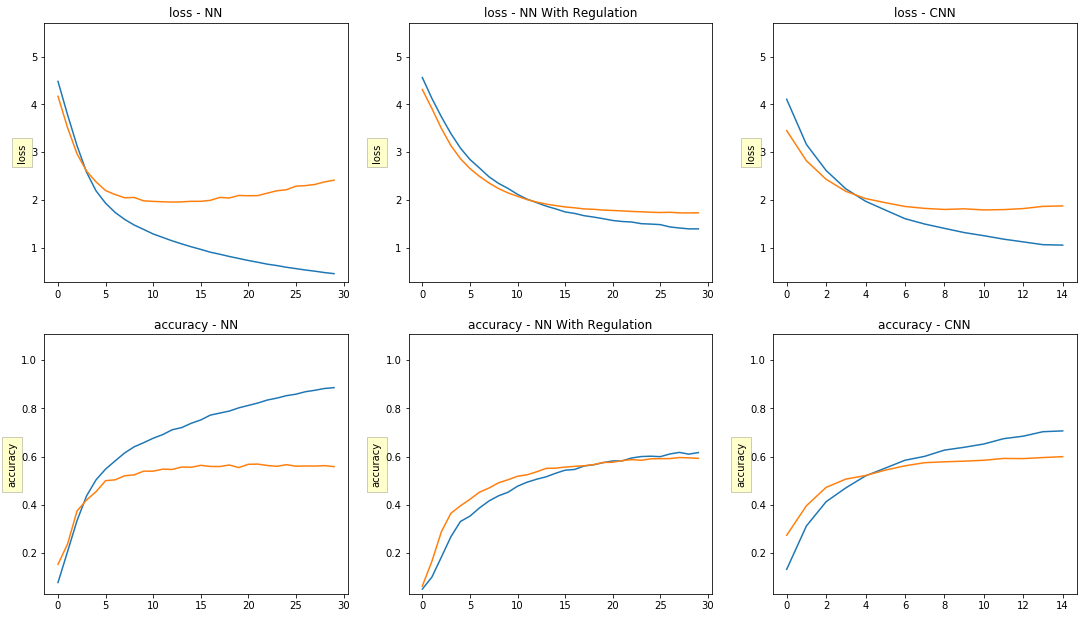

In [92]:
def make_plot(axs,
              model_history1, 
              model_history2,
              model_history3,
              model_1_name='NN',
              model_2_name='NN With Regulation',
              model_3_name='CNN'
              ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    for i, metric in enumerate(['loss', 'accuracy']):
        y_lim_lower1 = np.min(model_history1.history[metric])
        y_lim_lower2 = np.min(model_history2.history[metric])
        y_lim_lower3 = np.min(model_history3.history[metric])
        y_lim_lower = min(y_lim_lower1, y_lim_lower2) * 0.6

        y_lim_upper1 = np.max(model_history1.history[metric])
        y_lim_upper2 = np.max(model_history2.history[metric])
        y_lim_upper3 = np.max(model_history2.history[metric])
        y_lim_upper = max(y_lim_upper1, y_lim_upper2) * 1.25

        for j, model_history in enumerate([model_history1, model_history2, model_history3]):
            model_name = [model_1_name, model_2_name, model_3_name][j]
            ax1 = axs[i, j]
            ax1.plot(model_history.history[metric])
            ax1.plot(model_history.history['val_%s' % metric])
            ax1.set_title('%s - %s' % (metric, model_name))
            ax1.set_ylabel(metric, bbox=box)
            ax1.set_ylim(y_lim_lower, y_lim_upper)

fig, axs = plt.subplots(2, 3)

make_plot(axs,
          history1,
          history_2,
          history3,
          model_1_name='NN',
          model_2_name='NN With Regulation',
          model_3_name='CNN',
          )


fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()

In [ ]:
!pip install keras-tuner --upgrade



In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
import keras_tuner
build_model(keras_tuner.HyperParameters())

In [ ]:
hp = keras_tuner.HyperParameters()
print(hp.Int("units", min_value=32, max_value=512, step=32))

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
    model.add(GlobalMaxPool1D())
    model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.5))
    model.add(layers.Dense(42, activation="softmax"))
    learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


build_model(keras_tuner.HyperParameters())

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="helloworld",
)

In [ ]:
tuner.search_space_summary()

In [ ]:
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

In [ ]:
encoder = LabelEncoder()
encoder.fit(y_train)